In [1]:
import pandas as pd
import sys
sys.path.append("../")
import logging
import os
import numpy as np
from darts.models import NBEATSModel, TCNModel

Importing plotly failed. Interactive plots will not work.


In [2]:
from app.mlcode.determine_trading_state import DetermineTradingState
from app.mlcode.predict_price_movements import CoinPricePredictor
from app.mlcode.utils import read_in_data, read_in_yaml, running_on_aws, update_yaml_config

In [3]:
logger = logging.getLogger(__name__)

# Munge data into normal form

In [4]:
bitcoin_df = pd.read_csv("../data/historic_crypto_prices - bitcoin_jan_2017_sep_4_2021.csv", 
    index_col=0,
    parse_dates=True)

In [5]:
bitcoin_df

,open,high,low,close,volume
date,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,1.477750e+08
2017-01-02,998.62,1031.39,996.70,1021.75,2.221850e+08
2017-01-03,1021.60,1044.08,1021.60,1043.84,1.851680e+08
2017-01-04,1044.40,1159.42,1044.40,1154.73,3.449460e+08
2017-01-05,1156.73,1191.10,910.42,1013.38,5.101990e+08
...,...,...,...,...,...
2021-08-31,47024.34,48189.55,46750.09,47166.69,3.473036e+10
2021-09-01,47099.77,49111.09,46562.44,48847.03,3.913940e+10
2021-09-02,48807.85,50343.42,48652.32,49327.72,3.950807e+10


In [12]:
def convert_currency_to_float(input_df):
    for col in input_df.columns:
        input_df[col] = input_df[col].apply(lambda x: x.replace('$','').replace(",","")).astype(float)
    return input_df

In [13]:
bitcoin_df = convert_currency_to_float(bitcoin_df)

In [14]:
bitcoin_df = bitcoin_df.sort_index()
# don't get market cap from coinbase api
bitcoin_df.drop('market_cap' ,inplace=True, axis=1)

In [15]:
bitcoin_df.to_csv("../data/historic_crypto_prices - bitcoin_jan_2017_sep_4_2021.csv")

In [22]:
etherum_df = pd.read_csv("../data/historic_crypto_prices - etherum_jan_2017_sept_4_2021.csv", 
    index_col=0,
    parse_dates=True)

In [23]:
etherum_df

,open,high,low,close,volume
date,,,,,
2017-01-01,7.98,8.47,7.98,8.17,1.473170e+07
2017-01-02,8.17,8.44,8.05,8.38,1.457960e+07
2017-01-03,8.37,10.00,8.32,9.73,3.362520e+07
2017-01-04,9.71,11.28,9.56,11.25,4.105120e+07
2017-01-05,11.29,11.89,9.40,10.25,4.155740e+07
...,...,...,...,...,...
2021-08-31,3227.76,3466.99,3195.22,3433.73,2.728050e+10
2021-09-01,3430.76,3836.87,3387.41,3834.83,3.007089e+10
2021-09-02,3825.03,3830.71,3726.75,3790.99,2.438740e+10


In [19]:
etherum_df = convert_currency_to_float(etherum_df)

In [20]:
# don't get market cap from coinbase api
etherum_df = etherum_df.sort_index()
etherum_df.drop('market_cap' ,inplace=True, axis=1)

In [21]:
etherum_df.to_csv("../data/historic_crypto_prices - etherum_jan_2017_sept_4_2021.csv")

# Test code as imports
- make sure to download the latest data before running this

In [4]:
os.environ["ON_LOCAL"] = "True"

In [5]:
coin_to_predict = "eth"
is_running_on_aws = False #running_on_aws()
logger.info("Running determine trading state")

constants = read_in_yaml("../app/constants.yml", is_running_on_aws)
sys.stdout.flush()
trading_constants = read_in_yaml("../" + constants["trading_state_config_filename"], is_running_on_aws)
sys.stdout.flush()
won_and_lost_amount_constants = read_in_yaml("../" +constants["won_and_lost_amount_filename"], is_running_on_aws)
actions_to_take_constants = read_in_yaml("../" +constants["actions_to_take_filename"], is_running_on_aws)
# data should already be downloaded from the golang app
bitcoin_df = read_in_data("../" +constants["bitcoin_csv_filename"], is_running_on_aws)
etherum_df = read_in_data("../" +constants["etherum_csv_filename"], is_running_on_aws)
# spy_df = read_in_data(constants["spu_csv_filename"], is_running_on_aws, missing_dates=True)
ml_constants = read_in_yaml("../" + constants["ml_config_filename"], is_running_on_aws)
predictor = None

if coin_to_predict == "btc":
    predictor = CoinPricePredictor(
        coin_to_predict,
        constants,
        ml_constants,
        bitcoin_df,
        additional_dfs=[etherum_df],  # spy_df
    )
elif coin_to_predict == "eth":
    predictor = CoinPricePredictor(
        coin_to_predict,
        constants,
        ml_constants,
        etherum_df
    ) #         additional_dfs=[bitcoin_df],  # spy_df
else:
    raise ValueError(f"Incorrect coin to predict {coin_to_predict}. Needs to be eth or btc.")
sys.stdout.flush()

price_prediction = predictor.predict()
# print(price_prediction, "price_prediction")
logger.info("Determine trading state")

# predictor.df has the bollinger bands
trading_state_class = DetermineTradingState(
    coin_to_predict,
    price_prediction,
    constants,
    trading_constants,
    predictor.df,
    won_and_lost_amount_constants,
    actions_to_take_constants,
    is_running_on_aws,
)
sys.stdout.flush()
trading_state_class.calculate_positions()
logger.info("---- Finished determinig trading strategy --- ")
trading_state_class.update_state()

[10-15-2021 02:23:31] : INFO : 2548835700 : <module> : 3  Running determine trading state
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 47  Reading in ../app/constants.yml
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = btc_product_code Value = BTC/USD
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = eth_product_code Value = ETH/USD
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = spy_product_code Value = SPY/USD
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = candle_granularity Value = 86400
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = s3_bucket Value = go-trader
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = s3_data_location Value = data
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = s3_configs_locations Value = None
[10-15-2021 02:23:31] : INFO : utils : read_in_yaml : 56  Key = bitcoin_csv_filename Value = data/historic_crypto_prices - bitcoin_jan_2017_sep_4_20

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Why is training loss null
- ETH data below

In [6]:
np.sum(pd.isnull(etherum_df))

open              0
high              0
low               0
close             0
volume            0
Rolling Mean      9
Bollinger High    9
Bollinger Low     9
dtype: int64

In [7]:
np.sum(pd.isnull(bitcoin_df))

open              0
high              0
low               0
close             0
volume            0
Rolling Mean      9
Bollinger High    9
Bollinger Low     9
dtype: int64

In [13]:
pd.isnull(bitcoin_df)

,open,high,low,close,volume,Rolling Mean,Bollinger High,Bollinger Low
date,,,,,,,,
2017-01-01,False,False,False,False,False,True,True,True
2017-01-02,False,False,False,False,False,True,True,True
2017-01-03,False,False,False,False,False,True,True,True
2017-01-04,False,False,False,False,False,True,True,True
2017-01-05,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...
2021-10-10,False,False,False,False,False,False,False,False
2021-10-11,False,False,False,False,False,False,False,False
2021-10-12,False,False,False,False,False,False,False,False


In [14]:
predictor.df

,open,high,low,close,volume,Rolling Mean,Bollinger High,Bollinger Low
date,,,,,,,,
2019-01-01,133.42,141.40,132.65,140.82,2.258710e+09,133.902,146.752625,121.051375
2019-01-02,141.52,156.93,140.65,155.05,3.328240e+09,136.330,153.474263,119.185737
2019-01-03,155.20,155.86,147.20,149.14,2.676165e+09,137.220,155.709631,118.730369
2019-01-04,148.91,156.88,147.91,154.58,3.126193e+09,139.694,159.819991,119.568009
2019-01-05,154.34,160.82,154.34,155.64,3.338212e+09,142.071,163.320080,120.821920
...,...,...,...,...,...,...,...,...
2021-10-10,3573.30,3604.30,3408.50,3414.30,5.393185e+07,3473.970,3650.057204,3297.882796
2021-10-11,3414.30,3623.70,3372.90,3543.70,1.037350e+08,3497.240,3644.824329,3349.655671
2021-10-12,3543.70,3547.70,3404.00,3490.80,6.229953e+07,3507.410,3639.561446,3375.258554


In [16]:
np.sum(pd.isnull(predictor.df))

open              0
high              0
low               0
close             0
volume            0
Rolling Mean      0
Bollinger High    0
Bollinger Low     0
dtype: int64

<AxesSubplot:xlabel='date'>

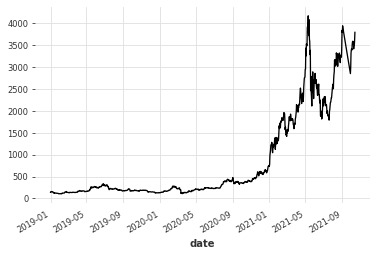

In [19]:
predictor.df['close'].plot()

In [19]:
np.sum(pd.isnull(predictor.additional_dfs[0]))

open              0
high              0
low               0
close             0
volume            0
Rolling Mean      0
Bollinger High    0
Bollinger Low     0
dtype: int64

In [14]:
# TODO, add holidays
predictor.ts_stacked_series

<TimeSeries (DataArray) (date: 1018, component: 16, sample: 1)>
array([[[0.00574379],
        [0.00688466],
        [0.00537608],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.00744881],
        [0.0084647 ],
        [0.00724932],
        ...,
        [0.        ],
        [0.        ],
        [0.03333333]],

       [[0.00880987],
        [0.00826465],
        [0.0073991 ],
        ...,
...
        ...,
        [1.        ],
        [0.81818182],
        [0.36666667]],

       [[0.87467643],
        [0.88459213],
        [0.86493985],
        ...,
        [1.        ],
        [0.81818182],
        [0.4       ]],

       [[0.89794564],
        [0.89701173],
        [0.90885502],
        ...,
        [1.        ],
        [0.81818182],
        [0.43333333]]])
Coordinates:
  * date       (date) datetime64[ns] 2019-01-01 2019-01-02 ... 2021-10-14
  * component  (component) <U16 'open' 'high' 'low' ... 'date_1' 'date_1_1'
Dimensions without coordinates: sample

In [13]:
predictor.ts_stacked_series.components

Index(['open', 'high', 'low', 'Rolling Mean', 'volume', 'Bollinger High',
       'close', 'open_1', 'high_1', 'low_1', 'Rolling Mean_1', 'volume_1',
       'Bollinger High_1', 'date', 'date_1', 'date_1_1'],
      dtype='object', name='component')

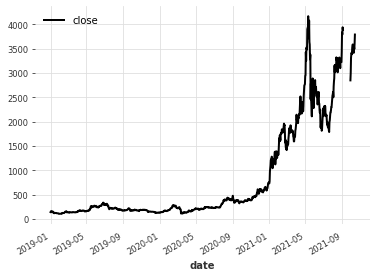

In [16]:
predictor.train_close_series.plot() ## nevermind

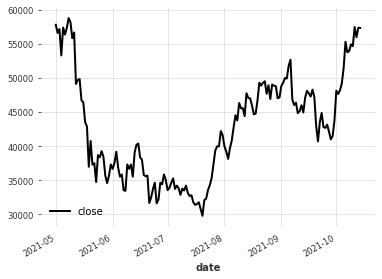

In [34]:
predictor.train_close_series.slice(pd.to_datetime('2021-05-01'), pd.to_datetime('2021-10-20')).plot()

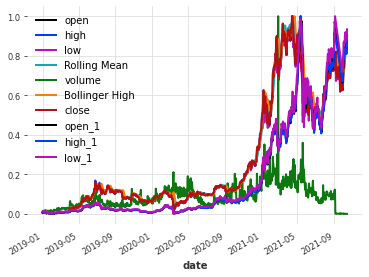

In [22]:
predictor.ts_stacked_series.plot()

In [42]:
new_model = TCNModel(input_chunk_length=15, output_chunk_length=14)

In [39]:
predictor.models[0][1].fit(predictor.train_close_series, past_covariates=[predictor.ts_stacked_series], epochs=20, verbose = True)

  0%|          | 0/20 [00:00<?, ?it/s]

#### rebuild the class

In [10]:
predictor.df ## this looks fine..

,open,high,low,close,volume,Rolling Mean,Bollinger High,Bollinger Low
date,,,,,,,,
2019-01-01,133.42,141.40,132.65,140.82,2.258710e+09,133.902,146.752625,121.051375
2019-01-02,141.52,156.93,140.65,155.05,3.328240e+09,136.330,153.474263,119.185737
2019-01-03,155.20,155.86,147.20,149.14,2.676165e+09,137.220,155.709631,118.730369
2019-01-04,148.91,156.88,147.91,154.58,3.126193e+09,139.694,159.819991,119.568009
2019-01-05,154.34,160.82,154.34,155.64,3.338212e+09,142.071,163.320080,120.821920
...,...,...,...,...,...,...,...,...
2021-10-10,3573.30,3604.30,3408.50,3414.30,5.393185e+07,3473.970,3650.057204,3297.882796
2021-10-11,3414.30,3623.70,3372.90,3543.70,1.037350e+08,3497.240,3644.824329,3349.655671
2021-10-12,3543.70,3547.70,3404.00,3490.80,6.229953e+07,3507.410,3639.561446,3375.258554


In [11]:
predictor.df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2019-01-01 to 2021-10-14
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            994 non-null    float64
 1   high            994 non-null    float64
 2   low             994 non-null    float64
 3   close           994 non-null    float64
 4   volume          994 non-null    float64
 5   Rolling Mean    994 non-null    float64
 6   Bollinger High  994 non-null    float64
 7   Bollinger Low   994 non-null    float64
dtypes: float64(8)
memory usage: 69.9 KB


## MISSING DATESSS!!

In [13]:
pd.date_range(start = predictor.df.index.min(), end = predictor.df.index.max() ).difference(predictor.df.index)

DatetimeIndex(['2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
               '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
               '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
               '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
               '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28'],
              dtype='datetime64[ns]', freq=None)

In [8]:
predictor.df

,open,high,low,close,volume,Rolling Mean,Bollinger High,Bollinger Low
date,,,,,,,,
2019-01-01,133.42,141.40,132.65,140.82,2.258710e+09,133.902,146.752625,121.051375
2019-01-02,141.52,156.93,140.65,155.05,3.328240e+09,136.330,153.474263,119.185737
2019-01-03,155.20,155.86,147.20,149.14,2.676165e+09,137.220,155.709631,118.730369
2019-01-04,148.91,156.88,147.91,154.58,3.126193e+09,139.694,159.819991,119.568009
2019-01-05,154.34,160.82,154.34,155.64,3.338212e+09,142.071,163.320080,120.821920
...,...,...,...,...,...,...,...,...
2021-10-10,3573.30,3604.30,3408.50,3414.30,5.393185e+07,3473.970,3650.057204,3297.882796
2021-10-11,3414.30,3623.70,3372.90,3543.70,1.037350e+08,3497.240,3644.824329,3349.655671
2021-10-12,3543.70,3547.70,3404.00,3490.80,6.229953e+07,3507.410,3639.561446,3375.258554


In [43]:
new_model.fit(predictor.train_close_series, past_covariates=[predictor.ts_stacked_series], epochs=20, verbose = True)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
predictor.models[0][1].fit(
    series=train_close_series,
    past_covariates=[ts_stacked_series],
    verbose=self.verbose,
    epochs=self.ml_constants["hyperparameters_tcn"]["epochs"],
)

- BTC data below

In [9]:
etherum_df

,open,high,low,close,volume
date,,,,,
2017-01-01,7.98,8.47,7.98,8.17,1.473170e+07
2017-01-02,8.17,8.44,8.05,8.38,1.457960e+07
2017-01-03,8.37,10.00,8.32,9.73,3.362520e+07
2017-01-04,9.71,11.28,9.56,11.25,4.105120e+07
2017-01-05,11.29,11.89,9.40,10.25,4.155740e+07
...,...,...,...,...,...
2021-10-10,3573.30,3604.30,3408.50,3414.30,5.393185e+07
2021-10-11,3414.30,3623.70,3372.90,3543.70,1.037350e+08
2021-10-12,3543.70,3547.70,3404.00,3490.80,6.229953e+07


In [10]:
predictor.df

,open,high,low,close,volume,Rolling Mean,Bollinger High,Bollinger Low
date,,,,,,,,
2019-01-01,3746.71,3850.91,3707.23,3843.52,4.324201e+09,NaN,NaN,NaN
2019-01-02,3849.22,3947.98,3817.41,3943.41,5.244857e+09,NaN,NaN,NaN
2019-01-03,3931.05,3935.69,3826.22,3836.74,4.530215e+09,NaN,NaN,NaN
2019-01-04,3832.04,3865.93,3783.85,3857.72,4.847965e+09,NaN,NaN,NaN
2019-01-05,3851.97,3904.90,3836.90,3845.19,5.137610e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-10-10,54956.00,56649.00,54111.00,54688.00,7.805949e+07,51753.9,57259.680871,46248.119129
2021-10-11,54686.00,57832.00,54441.00,57499.00,1.095697e+08,52687.0,58535.645337,46838.354663
2021-10-12,57499.00,57662.00,53888.00,56004.00,2.105858e+08,53520.6,58718.126528,48323.073472


In [11]:
predictor.additional_dfs

[               open     high      low    close        volume  Rolling Mean  \
 date                                                                         
 2019-01-01   133.42   141.40   132.65   140.82  2.258710e+09           NaN   
 2019-01-02   141.52   156.93   140.65   155.05  3.328240e+09           NaN   
 2019-01-03   155.20   155.86   147.20   149.14  2.676165e+09           NaN   
 2019-01-04   148.91   156.88   147.91   154.58  3.126193e+09           NaN   
 2019-01-05   154.34   160.82   154.34   155.64  3.338212e+09           NaN   
 ...             ...      ...      ...      ...           ...           ...   
 2021-10-10  3573.30  3604.30  3408.50  3414.30  5.393185e+07       3473.97   
 2021-10-11  3414.30  3623.70  3372.90  3543.70  1.037350e+08       3497.24   
 2021-10-12  3543.70  3547.70  3404.00  3490.80  6.229953e+07       3507.41   
 2021-10-13  3490.90  3613.40  3411.90  3607.90  5.904357e+07       3526.21   
 2021-10-14  3608.10  3824.90  3588.80  3791.70  4.1

In [12]:
predictor.ts_stacked_series

<TimeSeries (DataArray) (date: 1018, component: 16, sample: 1)>
array([[[0.00706881],
        [0.00830301],
        [0.01001136],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.00905899],
        [0.01195172],
        [0.01214882],
        ...,
        [0.        ],
        [0.        ],
        [0.03333333]],

       [[0.01242018],
        [0.01170033],
        [0.01389887],
        ...,
...
        ...,
        [1.        ],
        [0.81818182],
        [0.36666667]],

       [[0.8320045 ],
        [0.8240369 ],
        [0.88617193],
        ...,
        [1.        ],
        [0.81818182],
        [0.4       ]],

       [[0.86080064],
        [0.87372806],
        [0.93343664],
        ...,
        [1.        ],
        [0.81818182],
        [0.43333333]]])
Coordinates:
  * date       (date) datetime64[ns] 2019-01-01 2019-01-02 ... 2021-10-14
  * component  (component) <U16 'open' 'high' 'low' ... 'date_1' 'date_1_1'
Dimensions without coordinates: sample

In [13]:
predictor.ts_stacked_series.components

Index(['open', 'high', 'low', 'Rolling Mean', 'volume', 'Bollinger High',
       'close', 'open_1', 'high_1', 'low_1', 'Rolling Mean_1', 'volume_1',
       'Bollinger High_1', 'date', 'date_1', 'date_1_1'],
      dtype='object', name='component')

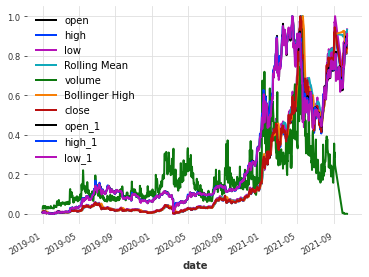

In [14]:
predictor.ts_stacked_series.plot()

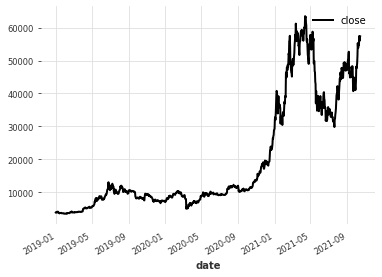

In [21]:
predictor.train_close_series.plot() ##  I think this is what's going wrong.... check btc

### Is BTC missing dates?
- NO!

In [15]:
pd.date_range(start = predictor.df.index.min(), end = predictor.df.index.max() ).difference(predictor.df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)